In [18]:
import pandas as pd
import numpy as np
import os
import sys
from scipy.sparse import csr_matrix
from  scipy import sparse

In [2]:
def create_coocc_matrix(df, col_1,col_2):
    set_elements_1 = set(list(df[col_1]))
    set_elements_2 = set(list(df[col_2]))
    count_1 = len(set_elements_1)
    count_2 = len(set_elements_2)
    coocc = np.zeros([count_1,count_2])
    df = df[[col_1,col_2]]
    new_df = df.groupby([col_1, col_2]).size().reset_index(name='count')
    
    for _, row in new_df.iterrows():
        i = row[col_1]
        j = row[col_2]
        coocc[i][j] = row['count']
        
    return csr_matrix(coocc)


In [3]:
df = pd.read_csv('./../../generated_data_v1/china_export/train_data.csv')

In [7]:
columnWise_coOcc_array_dict = {}

In [8]:
columns = list(df.columns)
id_col = 'PanjivaRecordID'
columns.remove(id_col)
columns = list(sorted(columns))
columnWise_coOcc_array_dict = {}
for i in range(len(columns)):
    for j in range(i+1,len(columns)):
        col_1 = columns[i]
        col_2 = columns[j]
        key = col_1 + '_+_' + col_2
        res = create_coocc_matrix(df, col_1,col_2)
        columnWise_coOcc_array_dict[key] = res

In [59]:
columnWise_coOcc_array_dict.keys()

dict_keys(['AdminRegion_+_CountryOfSale', 'AdminRegion_+_HSCode', 'AdminRegion_+_Province', 'AdminRegion_+_ShipmentDestination', 'AdminRegion_+_ShipperPanjivaID', 'AdminRegion_+_TradeType', 'AdminRegion_+_TransportMethod', 'CountryOfSale_+_HSCode', 'CountryOfSale_+_Province', 'CountryOfSale_+_ShipmentDestination', 'CountryOfSale_+_ShipperPanjivaID', 'CountryOfSale_+_TradeType', 'CountryOfSale_+_TransportMethod', 'HSCode_+_Province', 'HSCode_+_ShipmentDestination', 'HSCode_+_ShipperPanjivaID', 'HSCode_+_TradeType', 'HSCode_+_TransportMethod', 'Province_+_ShipmentDestination', 'Province_+_ShipperPanjivaID', 'Province_+_TradeType', 'Province_+_TransportMethod', 'ShipmentDestination_+_ShipperPanjivaID', 'ShipmentDestination_+_TradeType', 'ShipmentDestination_+_TransportMethod', 'ShipperPanjivaID_+_TradeType', 'ShipperPanjivaID_+_TransportMethod', 'TradeType_+_TransportMethod'])

In [85]:
m = columnWise_coOcc_array_dict['CountryOfSale_+_TransportMethod']

In [86]:
values = sparse.find(m)[2]

In [69]:
import matplotlib.pyplot as plt

In [70]:
np.mean(values)


133.41599331290053

In [71]:
np.std(values)

624.176732104844

(array([588.,  13.,  10.,   4.,   5.,   4.,   1.,   1.,   2.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.]),
 array([1.000000e+00, 2.256360e+03, 4.511720e+03, 6.767080e+03,
        9.022440e+03, 1.127780e+04, 1.353316e+04, 1.578852e+04,
        1.804388e+04, 2.029924e+04, 2.255460e+04, 2.480996e+04,
        2.706532e+04, 2.932068e+04, 3.157604e+04, 3.383140e+04,
        3.608676e+04, 3.834212e+04, 4.059748e+04, 4.285284e+04,
        4.510820e+04, 4.736356e+04, 4.961892e+04, 5.187428e+04,
        5.412964e+04, 5.638500e+04]),
 <a list of 25 Patch objects>)

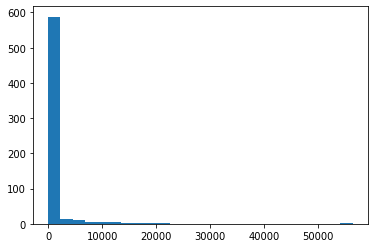

In [87]:
plt.hist(values,bins=25)

-----> AdminRegion_+_CountryOfSale
1.0 4178.0 22.52999576530372 1.0


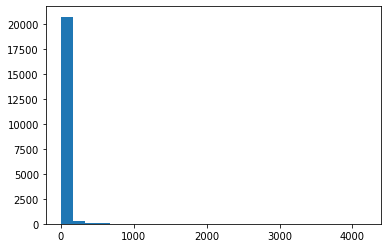

-----> AdminRegion_+_HSCode
1.0 4931.0 33.03187086092715 1.0


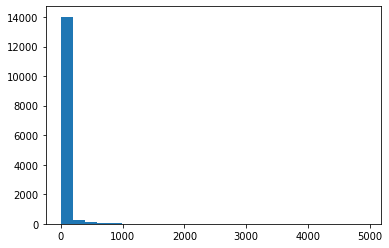

-----> AdminRegion_+_Province
3.0 32423.0 973.2317073170732 12.0


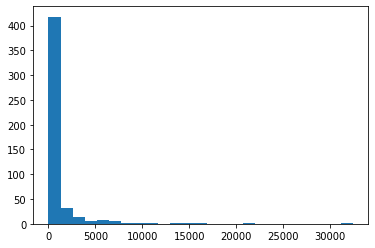

-----> AdminRegion_+_ShipmentDestination
1.0 4489.0 22.42973580663294 1.0


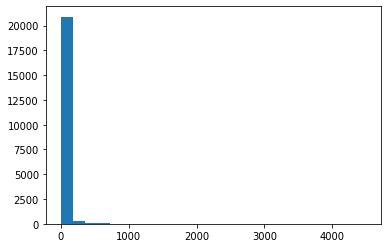

-----> AdminRegion_+_ShipperPanjivaID
1.0 4715.0 33.739430665163475 6.0


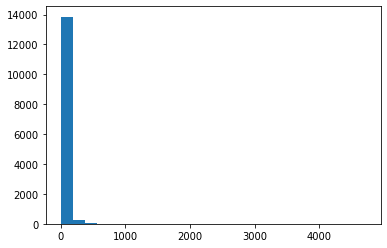

-----> AdminRegion_+_TradeType
1.0 31206.0 489.1011235955056 4.0


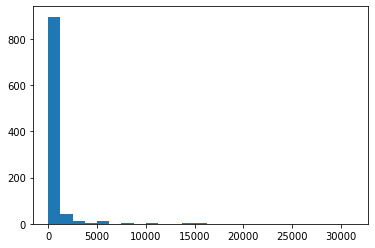

-----> AdminRegion_+_TransportMethod
1.0 32149.0 374.9647611589663 2.0


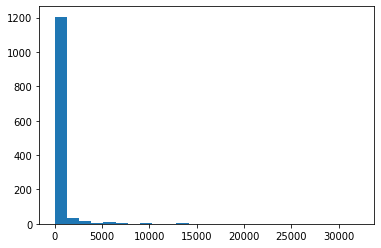

-----> CountryOfSale_+_HSCode
1.0 5775.0 42.291997880233176 1.0


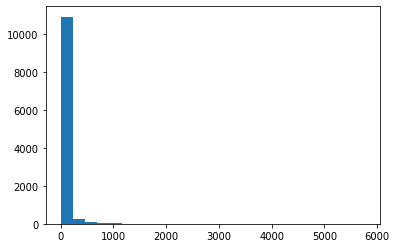

-----> CountryOfSale_+_Province
1.0 17991.0 133.60212053571428 1.0


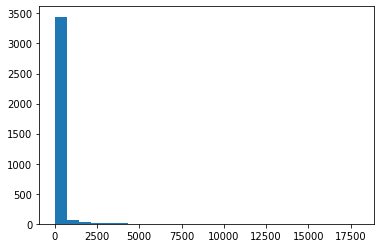

-----> CountryOfSale_+_ShipmentDestination
1.0 62256.0 878.5871559633027 1.0


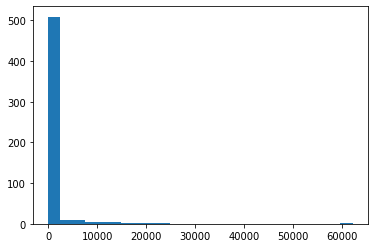

-----> CountryOfSale_+_ShipperPanjivaID
1.0 469.0 4.010738187574861 1.0


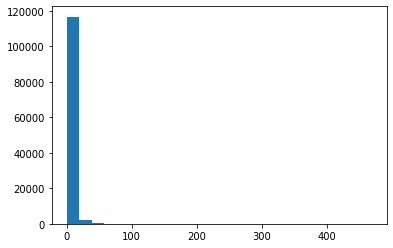

-----> CountryOfSale_+_TradeType
1.0 54144.0 498.26222684703436 2.0


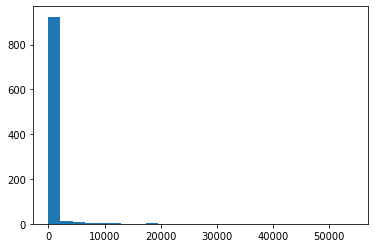

-----> CountryOfSale_+_TransportMethod
1.0 56385.0 760.047619047619 1.0


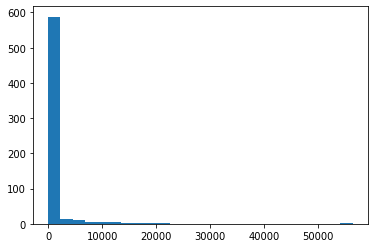

-----> HSCode_+_Province
1.0 13128.0 184.59136468774093 1.0


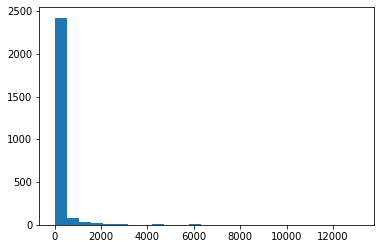

-----> HSCode_+_ShipmentDestination
1.0 5818.0 42.20625826355223 1.0


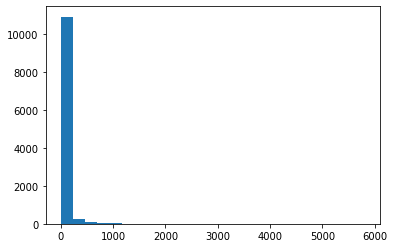

-----> HSCode_+_ShipperPanjivaID
1.0 476.0 6.23460326553996 1.0


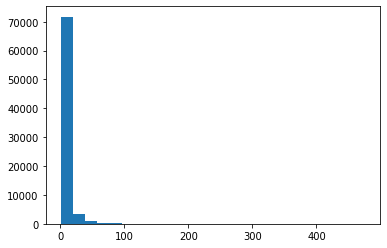

-----> HSCode_+_TradeType
1.0 37455.0 586.8014705882352 1.0


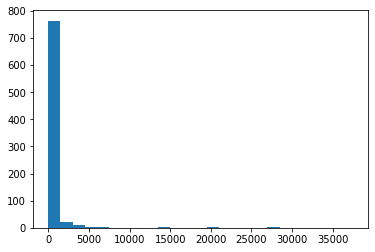

-----> HSCode_+_TransportMethod
1.0 42783.0 975.2138492871691 2.0


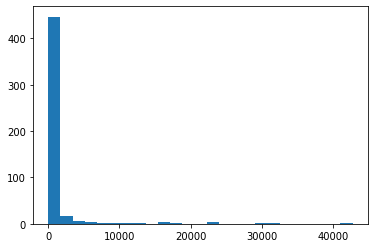

-----> Province_+_ShipmentDestination
1.0 18610.0 133.41599331290053 1.0


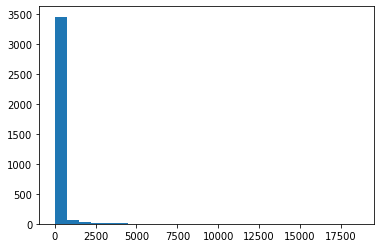

-----> Province_+_ShipperPanjivaID
1.0 4715.0 33.90907159549607 6.0


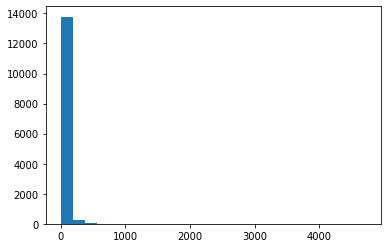

-----> Province_+_TradeType
1.0 96147.0 3302.2758620689656 6.0


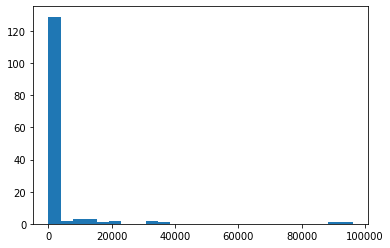

-----> Province_+_TransportMethod
1.0 121110.0 3683.3076923076924 4.9


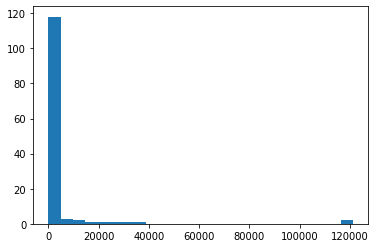

-----> ShipmentDestination_+_ShipperPanjivaID
1.0 469.0 3.9891529829296943 1.0


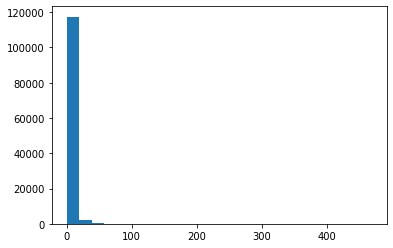

-----> ShipmentDestination_+_TradeType
1.0 54363.0 492.62345679012344 2.0


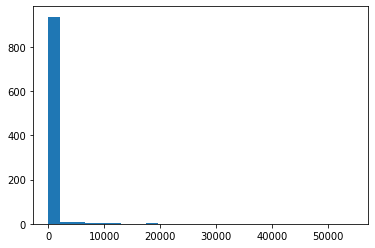

-----> ShipmentDestination_+_TransportMethod
1.0 56555.0 743.5248447204968 1.0


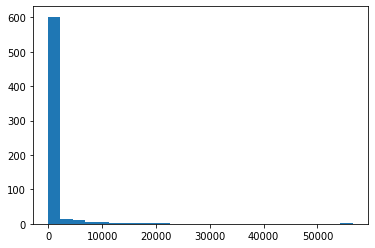

-----> ShipperPanjivaID_+_TradeType
1.0 4715.0 31.230759196451867 5.0


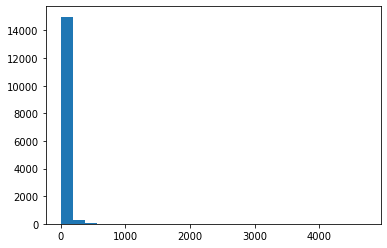

-----> ShipperPanjivaID_+_TransportMethod
1.0 4223.0 23.64008886694643 1.0


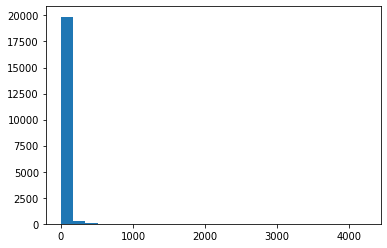

-----> TradeType_+_TransportMethod
1.0 344603.0 13300.833333333334 5.0


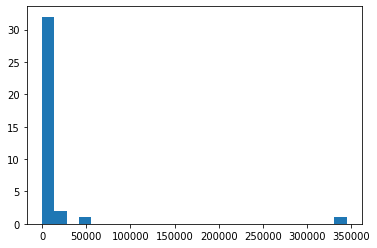

In [91]:
for k in columnWise_coOcc_array_dict.keys():
    print('----->', k)
    m = columnWise_coOcc_array_dict[k]
    values = sparse.find(m)[2]
    print(np.min(values),np.max(values),np.mean(values),np.percentile(values,10))
    plt.hist(values,bins=25)
    plt.show()


In [89]:
np.percentile(values,25)

3.0